In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('november_2024_data.csv')
data.head()

,date,client,triggers,retriggers,notifications,component1,component2,component3
0,20241101,c1,1,10,11,2,0,9
1,20241101,c2,3,15,18,6,0,12
2,20241101,c3,2,1,3,2,1,0
3,20241101,c4,3,13,16,0,3,13
4,20241101,c5,1,3,4,1,2,1


In [3]:
df.dtypes

date              int64
client           object
triggers          int64
retriggers        int64
notifications     int64
component1        int64
component2        int64
component3        int64
dtype: object

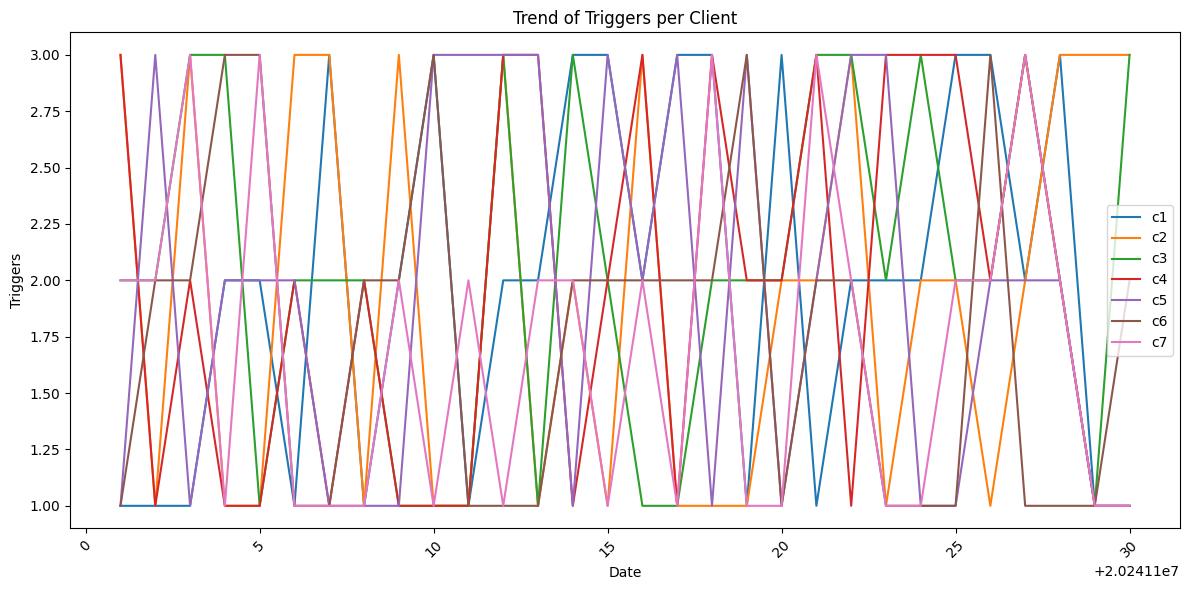

In [5]:
# Question 1: Trend of triggers per client in the given time frame
def plot_triggers_trend(data):
    triggers_trend = data.groupby(["date", "client"])["triggers"].sum().reset_index()
    plt.figure(figsize=(12, 6))
    for client in data["client"].unique():
        client_data = triggers_trend[triggers_trend["client"] == client]
        plt.plot(client_data["date"], client_data["triggers"], label=client)
    plt.xlabel("Date")
    plt.ylabel("Triggers")
    plt.title("Trend of Triggers per Client")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_triggers_trend(data)

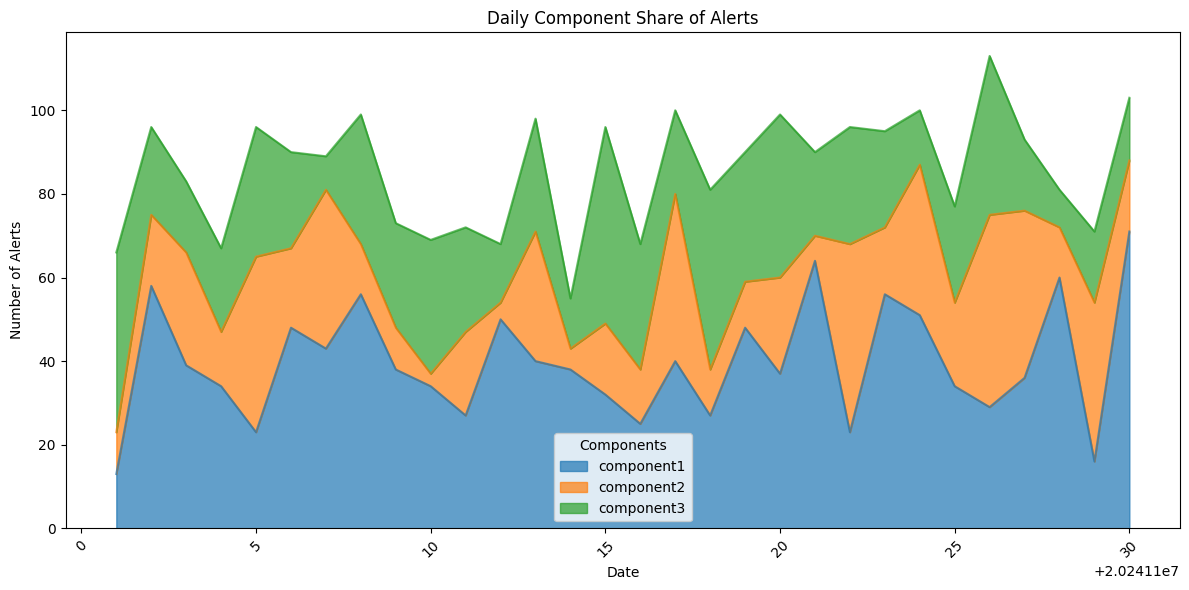

In [6]:
# Question 2: Component share of alerts every day in the given time frame
def plot_component_share(data):
    daily_components = data.groupby("date")[["component1", "component2", "component3"]].sum()
    daily_components.plot(kind="area", figsize=(12, 6), stacked=True, alpha=0.7)
    plt.title("Daily Component Share of Alerts")
    plt.xlabel("Date")
    plt.ylabel("Number of Alerts")
    plt.xticks(rotation=45)
    plt.legend(title="Components")
    plt.tight_layout()
    plt.show()

plot_component_share(data)

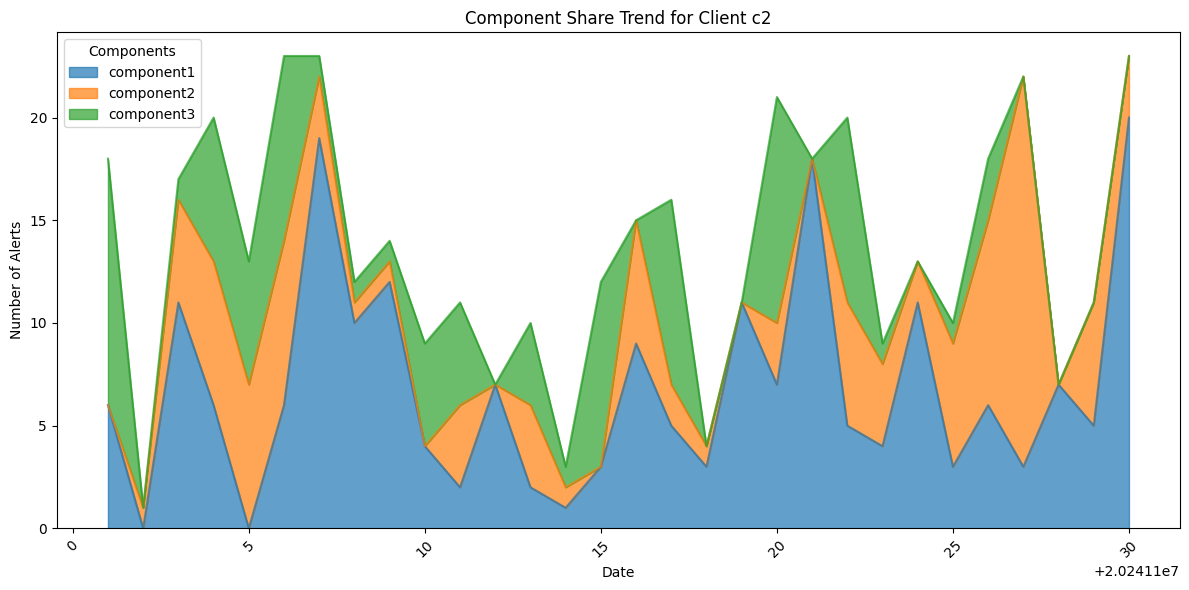

In [8]:
# Question 3: Trend of component share for a given client in the given time frame
def plot_client_component_trend(data, client):
    client_data = data[data["client"] == client]
    client_components = client_data.groupby("date")[["component1", "component2", "component3"]].sum()
    client_components.plot(kind="area", figsize=(12, 6), stacked=True, alpha=0.7)
    plt.title(f"Component Share Trend for Client {client}")
    plt.xlabel("Date")
    plt.ylabel("Number of Alerts")
    plt.xticks(rotation=45)
    plt.legend(title="Components")
    plt.tight_layout()
    plt.show()

# Example for a given client (e.g., "c1")
plot_client_component_trend(data, "c2")